# Introduction to Python for Earth Scientists

These notebooks have been developed by Calum Chamberlain, Finnigan Illsley-Kemp and John Townend at [Victoria University of Wellington-Te Herenga Waka](https://www.wgtn.ac.nz) for use by Earth Science graduate students. 

The notebooks cover material that we think will be of particular benefit to those students with little or no previous experience of computer-based data analysis. We presume very little background in command-line or code-based computing, and have compiled this material with an emphasis on general tasks that a grad student might encounter on a daily basis. 

In 2022, this material will be delivered at the start of Trimester 1 in conjunction with [ESCI451 Active Earth](https://www.wgtn.ac.nz/courses/esci/451/2022/offering?crn=32176). Space and pandemic alert levels permitting, interested students not enrolled in ESCI451 are encouraged to come along too but please contact Calum, Finn, or John first.

| Notebook | Contents | Data |
| --- | --- | --- |
| [1A](ESCI451_Module_1A.ipynb) | Introduction to programming, Python, and Jupyter notebooks | - |
| [1B](ESCI451_Module_1B.ipynb) | Basic data types and variables, getting data, and plotting with Matplotlib | Geodetic positions |
| [2A](ESCI451_Module_2A.ipynb) | More complex plotting, introduction to Numpy | Geodetic positions; DFDP-2B temperatures |
| [2B](ESCI451_Module_2B.ipynb) | Using Pandas to load, peruse and plot data | Earthquake catalogue  |
| [3A](ESCI451_Module_3A.ipynb) | Working with Pandas dataframes | Geochemical data set; GNSS data |
| **[3B](ESCI451_Module_3B.ipynb)** | **Simple time series analysis using Pandas** | **Historical temperature records** |
| [4A](ESCI451_Module_4A.ipynb) | Making maps with PyGMT | Earthquake catalogue |
| [4B](ESCI451_Module_4B.ipynb) | Gridded data and vectors | Ashfall data and GNSS |

The content may change in response to students' questions or current events. Each of the four modules has been designed to take about three hours, with a short break between each of the two parts.

# This notebook

1. Working with time series using dataframes
   - Loading and wrangling data
   - Plotting subsets of time series data using Matplotlib, Pandas, and hybrid approaches
   - Merging dataframes
   - Illustrating periodicity
   - Rolling averages  

# Working with time series using dataframes

## Loading and wrangling data

In this module we'll look at analysing time series data using Pandas. We'll work with temperature data obtained from the NIWA CliFlo database over several decades in the twentieth century. Our emphasis is on widely useable techniques for working with time series data, rather than advanced techniques used in specific fields.

First, let's load some of the standard tools.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dateutil import parser, rrule
from datetime import datetime as dt
import requests
import time
import seaborn as sns

Next, we'll load the CliFlo data from .csv (comma-separated variable) files downloaded previously. There are four files to work with:

- 1939-1989-surface-temperature-CliFlo.csv - daily minimum and maximum surface temperatures measured at Kelburn between 1939 and 1989
- 1939-1989-10cm-temperature-CliFlo.csv - daily temperature measurements at 10 cm depth, measured at Kelburn between 1939 and 1989
- 1939-1989-30cm-temperature-CliFlo.csv - " " " 30 cm depth " " "
- 1939-1989-100cm-temperature-CliFlo.csv - " " " 100 cm depth " " "

You may recall from other classes (e.g. ESCI203!) that surface temperature variations of different frequencies propagate to different depths. By looking at amplitude and phase characteristics of the various data sets we may be able to observe this phenomena.

The first column of each of these files contains the measurement date in the format '%Y%m%d:%H%M' (e.g. "19390105:0900"), and we can customise the Pandas `read_csv` command by telling it to treat the Date column in the .csv file as a list of dates with that specific format. We can also specify that the Date information be used as the index of each dataframe.

In [2]:
def parser(date): return dt.strptime(date, '%Y%m%d:%H%M')


T0 = pd.read_csv(
    'data/1939-1989-surface-temperature-CliFlo.csv',
    parse_dates=['Date'], date_parser=parser, index_col='Date')
T10 = pd.read_csv(
    'data/1939-1989-10cm-temperature-CliFlo.csv',
    parse_dates=['Date'], date_parser=parser, index_col='Date')
T30 = pd.read_csv(
    'data/1939-1989-30cm-temperature-CliFlo.csv',
    parse_dates=['Date'], date_parser=parser, index_col='Date')
T100 = pd.read_csv(
    'data/1939-1989-100cm-temperature-CliFlo.csv',
    parse_dates=['Date'], date_parser=parser, index_col='Date')

Each of the dataframes we've created has the same format, with the exception that the surface temperatures are expressed as minimum and maximum values. Remember, we can inspect or verify different aspects of a dataframe using commands like `df.columns` (to see a list of column names) and `df.describe()` (to get summary statistics), or just by entering `df` to see a summary of the first few rows:

In [3]:
T0

,Tmax,Tmin
Date,,
1939-12-31 09:00:00,21.3,14.3
1940-01-01 09:00:00,22.8,14.6
1940-01-02 09:00:00,23.1,11.3
1940-01-03 09:00:00,15.3,7.9
1940-01-04 09:00:00,17.9,9.0
...,...,...
1989-12-26 08:00:00,18.8,13.3
1989-12-27 08:00:00,19.1,14.6
1989-12-28 08:00:00,19.2,14.9


Before going any further, we're going to spend a bit of time manipulating each of the four dataframes we've created to put it into the most convenient format possible. This type of process is often referred to as "data wrangling" by cool Python types.

In the case of the surface measurements, T0, we will calculate a rough mean daily temperature by averaging the maximum and minimum values. (Climate scientists would do this much more carefully and would likely use hourly records for this.)

In [4]:
T0['Temperature'] = T0.apply(lambda df: (df['Tmax'] + df['Tmin']) / 2, axis=1)

That may need some explanation. What we've done is to create a new column in the T0 dataframe with the name `Temperature`, and we've done this using a function applied to the `Tmax` and `Tmin` columns. The function is specified as "lambda df: (df['Tmax']+df['Tmin'])/2" and then applied via "T0.apply(...)". "axis=1" in the function definition tells Python to operate on columns rather than rows.

Let's check what the form of T0 is now:

In [5]:
T0

,Tmax,Tmin,Temperature
Date,,,
1939-12-31 09:00:00,21.3,14.3,17.80
1940-01-01 09:00:00,22.8,14.6,18.70
1940-01-02 09:00:00,23.1,11.3,17.20
1940-01-03 09:00:00,15.3,7.9,11.60
1940-01-04 09:00:00,17.9,9.0,13.45
...,...,...,...
1989-12-26 08:00:00,18.8,13.3,16.05
1989-12-27 08:00:00,19.1,14.6,16.85
1989-12-28 08:00:00,19.2,14.9,17.05


## Plotting subsets of time series data using Matplotlib, Pandas, and hybrid approaches

Notice that because of how we read the data in originally, we don't have an integer index colum (0, 1, 2, 3...) but instead have the Date values. This will necessitate a few changes in how we refer to the dates but we can address these as they come up. 

In any case, now's the time to get an idea of what the data look like by just plotting each dataframe. Right away, this requires us to remember that the dataframe index is the Date information, which means that we can't refer to it using a column name. We have three options (at least!) here. 
1. Either we can use "pure" Matplotlib syntax and specify the x-data using the syntax `df.index` instead of `df['Date']`
2. Or we can use the in-built plotting options for a Pandas dataframe and just omit any mention of the x-data
3. Or we can use a hybrid approach, which enables us to use some of the more sophisticated layout and annotation options Matplotlib provides without having to specify the x-data at all.

Let's try all three to see what happens and, for the sake of reinforcing things we've looked at previously, let's use loops wherever possible. We'll also use this opportunity to experiment a little bit with different layouts.


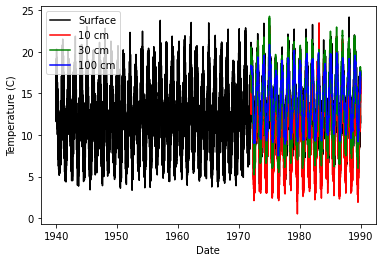

In [6]:
# 1. Pure Matplotlib
fig, ax = plt.subplots()
for component, colour, label in zip([T0, T10, T30, T100], ["black", "red", "green", "blue"], ['Surface', '10 cm', '30 cm', '100 cm']):
    ax.plot(component.index,
            component['Temperature'], color=colour, label=label)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (C)')
ax.legend()
plt.show()

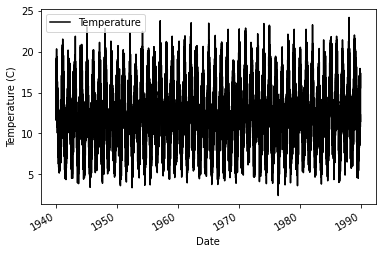

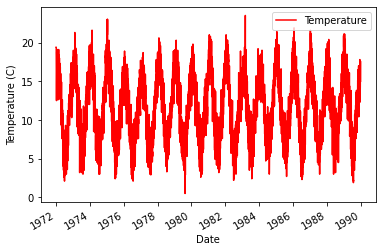

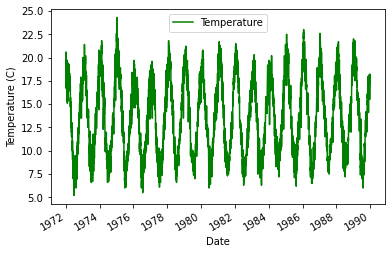

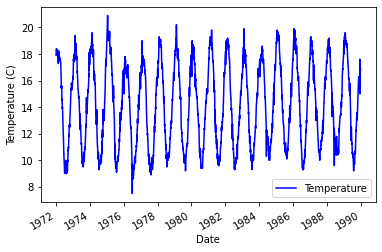

In [7]:
# 2. Pure Pandas plotting
for component, colour, label in zip([T0, T10, T30, T100], ["black", "red", "green", "blue"], ['Surface', '10 cm', '30 cm', '100 cm']):
    ax = component.plot(y=['Temperature'], color=colour)
    ax.set_ylabel('Temperature (C)')

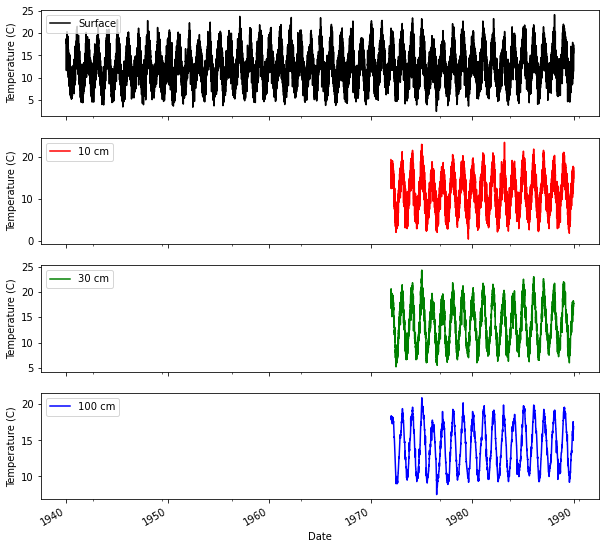

In [8]:
# 3. Hybrid
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
for i, component, colour, label in zip([0, 1, 2, 3], [T0, T10, T30, T100], ["black", "red", "green", "blue"], ['Surface', '10 cm', '30 cm', '100 cm']):
    component['Temperature'].plot(ax=axes[i], label=label, color=colour)
    axes[i].legend()
    axes[i].set_ylabel('Temperature (C)')

Groovy!

But what we can see from this is the surface records start much further back in time than the others. We could adjust for this in the plot by simply setting the x-axis limits to the date ranges spanned by the subsurface data, but perhaps a better way of handling this is to create a _single_ combined dataframe with all the different temperature measurements for the data range spanned by all the datasets. Clear as mud?

## Merging dataframes

This gives us the opportunity to talk about different ways of joining dataframes sharing a common field (known as the "join key" and in this case the Date information in each dataframe). There's a really helpful explanation of some of the multitudinous options [here](https://datacarpentry.org/python-ecology-lesson/05-merging-data/index.html) but we'll look at just a couple of points. 

- What we could do here is combine some or all of the the columns from two dataframes at a time based on a common join key, and then output only those rows that have matching join key values in both of the input dataframes. This is called an "inner join".

- Alternatively, we could output all the rows of one of the input dataframes augmented with data from the other when there's a matching join key value and augmented with nulls otherwise. This technique yields a "left join" or a "right join", depending on the order of input dataframes.

- There's also something called an "outer join" which is a bit like doing left and right joins at the same time in the sense that it retains all the rows from both input dataframes and inserts null values as needed for rows without a matching join key.

For our purposes, and given that we've seen already that the surface dataset starts much earlier than the others, it seems most appropriate to do an inner join.



In [9]:
merged1 = pd.merge(left=T0, right=T10, how='inner',
                   left_on='Date', right_on='Date')

Can you see how we'd have got the same answer in this case if we had specified "how='right'"? Notice also that the temperature columns from T0 and T10 have been relabled as "Temperature_x" and "Temperature_y" to avoid two columns with the same name. It's probably a good idea to rename them now to avoid getting confused about which temperature is which later.

In [10]:
merged1.rename(columns={'Temperature_x': 'T0',
               'Temperature_y': 'T10'}, inplace=True)

We can do this a couple more times using the remaining dataframes. Since each dataframe's index is the Date information itself, we can equally well use the following syntax (i.e. specifying the join key as the index):

In [11]:
merged2 = pd.merge(left=merged1, right=T30, how='inner',
                   left_index=True, right_index=True)
merged2.rename(columns={'Temperature': 'T30'}, inplace=True)
temperatures = pd.merge(left=merged2, right=T100,
                        how='inner', left_index=True, right_index=True)
temperatures.rename(columns={'Temperature': 'T100'}, inplace=True)

OK. Now we're ready to actually analyse the data in a bit more detail. But let's remind ourselves of some of the ways we can slice the data to look at particular details. Of no particular significance:

1. The temperature at various depths on your birthday?
2. The maximum _surface_ temperature in the whole dataset?
3. The maximum and minimum temperatures at a depth of 100 cm in a particular month or year?

In [12]:
print(temperatures.loc['1972-12-12'])
print(temperatures.loc['1980']['Tmax'].max())
print(temperatures.loc['1988']['T100'].max(),
      temperatures.loc['1988']['T100'].min())

                     Tmax  Tmin    T0   T10   T30  T100
Date                                                   
1972-12-12 09:00:00  19.7  12.9  16.3  16.1  17.3  15.6
24.9
19.2 9.6


We can do some simple plotting of various subsets too:

1. The surface temperature in a particular month or year?
2. The subsurface temperature records in three successive months?
3. The subsurface temperatures in the same month of several successive years?
4. Shallow (T0) vs deep (T100) temperatures in a particular year?


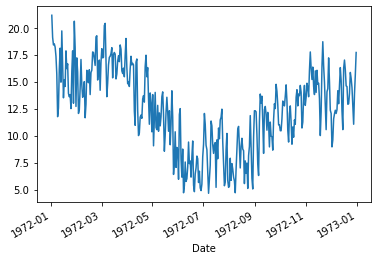

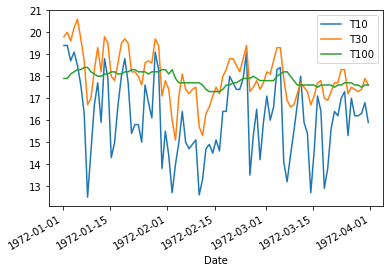

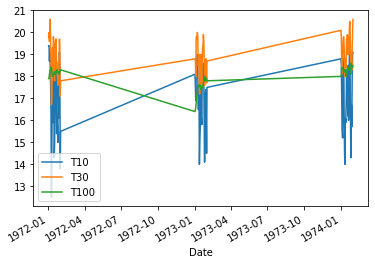

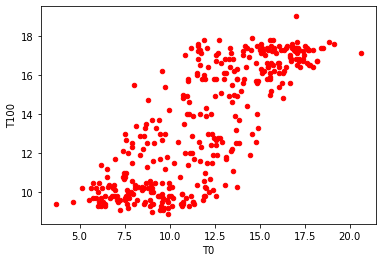

In [13]:
temperatures.loc['1972']['T0'].plot()
temperatures.loc['1972-01':'1972-03'][['T10', 'T30', 'T100']].plot()
pd.concat([temperatures.loc['1972-01'][['T10', 'T30', 'T100']],
           temperatures.loc['1973-01'][['T10', 'T30', 'T100']],
           temperatures.loc['1974-01'][['T10', 'T30', 'T100']]]).plot()
temperatures.loc['1977'].plot.scatter(x='T0', y='T100', c='red')
plt.show()

(That third one was a bit silly.)

## Illustrating periodicity

We can see right away that there are strong annual cycles but there may be other features in the data that we want to look at. 

Let's try plotting all the data on a single year-long time axis. This is easily done using a pivot table, in which we effectively reshape the dataframe into a format in which the columns represent day of the year or month, for example, and the columns represent different years. In this first example, we are concatenating two commands together (`.pivotable` and `.plot`) and plotting each year's data against the day of the year. 

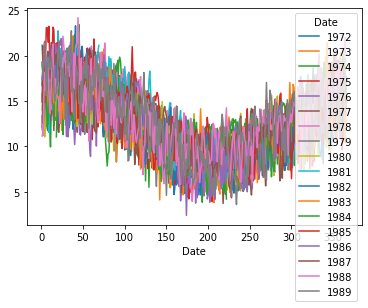

In [14]:
pivot = temperatures.pivot_table(
    'T0', index=temperatures.index.dayofyear,
    columns=temperatures.index.year, aggfunc='mean')
pivot.plot()
plt.show()

See how we are forming the pivot table's index list (i.e. row names) by extracting day-of-the-year inforamtion from the existing dates (`index=temperatures.index.dayofyear`) and forming the column names by extracting the year information (`columns=temperatures.index.year`). We're also computing the mean of the data in each cell of the pivot table, although in this case there should only be one measurement taken per day anyway. You can find more helpful information about pivot tables [here](https://jakevdp.github.io/PythonDataScienceHandbook/03.09-pivot-tables.html).

Here's the same type of graph but illustrated with respect to months rather than days: (in this case we're plotting the pivot table directly, rather than outputting a new dataframe)

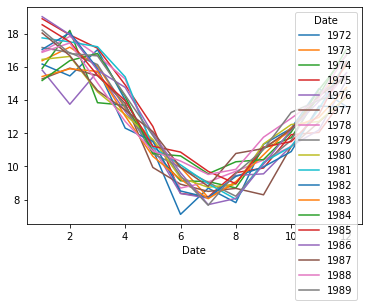

In [15]:
temperatures.pivot_table(
    'T0', index=temperatures.index.month,
    columns=temperatures.index.year, aggfunc='mean').plot()
plt.show()

For comparison, here's another way of doing something similar but without retaining the yearly curves, which have been crunched into a single 12-month average temperature record.

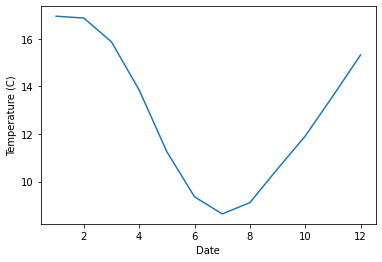

In [16]:
fig, ax = plt.subplots()
temperatures['T0'].groupby(temperatures.index.month).mean().plot()
ax.set_ylabel('Temperature (C)')
plt.show()

Finally, let's use some of the very elegant plotting options provided by `seaborn` to doing something similar in a different way (see more [here](http://seaborn.pydata.org/examples/)).

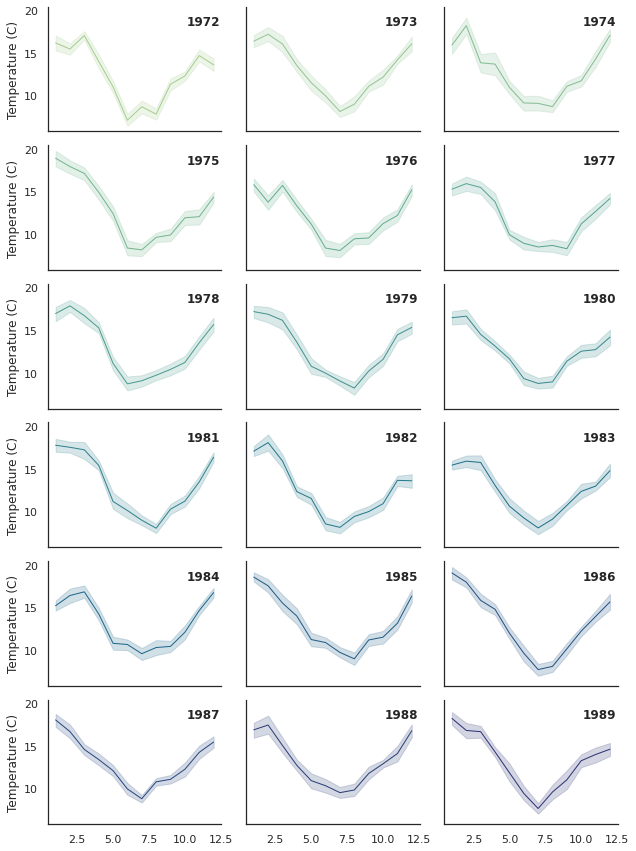

In [17]:
# Plot each year's time series in its own panel
sns.set_theme(style="white")
g = sns.relplot(
    data=temperatures,
    x=temperatures.index.month, y=temperatures['T0'], col=temperatures.index.year, hue=temperatures.index.year,
    kind="line", palette="crest", linewidth=1, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False
)

# Annotate each plot with the year
for year, ax in g.axes_dict.items():
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

# Tweak the layout a bit
g.set_titles("")
g.set_axis_labels("", "Temperature (C)")
g.tight_layout()

As you can see, there are many different ways to inspect and plot your data.

## Rolling averages

Finally, we'll briefly experiment with showing rolling averages and with calculating the lags between different temperature records.

Rolling averages, as the name suggests, are averages computed in a moving window of the data. 

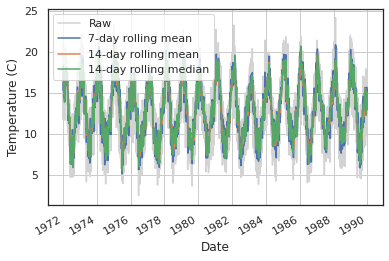

In [18]:
ax = temperatures.plot(y='T0', color='lightgray', label='Raw')
temperatures['T0'].rolling(window=7).mean().plot(label='7-day rolling mean')
temperatures['T0'].rolling(window=14).mean().plot(label='14-day rolling mean')
temperatures['T0'].rolling(window=14).median().plot(
    label='14-day rolling median')
ax.grid()
ax.legend()
ax.set_ylabel('Temperature (C)')
plt.show()